In [1]:
import pandas as pd
import numpy as np
import phdTools
from termcolor import colored
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.transforms as transforms
from matplotlib import rc
import datetime

In [2]:
from IPython.display import display, set_matplotlib_formats

In [3]:
# Set the matplotlib graphs to be exported as pdf
set_matplotlib_formats('svg')

In [4]:
# Output markdown to cells
from IPython.display import Markdown

---
## Peak event data

It gives temporal related data:
* **Start** and **end** datetime of each peak event

In [5]:
# Read Peak event data
url_path = 'https://data.gov.au/dataset/4e21dea3-9b87-4610-94c7-15a8a77907ef/resource/e45517ea-189a-4d61-b02d-bd7d85b0f156/download/sgsc-ctpeak-events.csv'
peak_event_df = pd.read_csv(url_path)

In [6]:
# Trim leading and trailing whitespaces in column names
peak_event_df.columns = peak_event_df.columns.str.strip()

In [7]:
peak_event_df.head()

,EVENT_KEY,PEAK_EVENT_TYPE,EVENT_DATE,START_TIMESTAMP,END_TIMESTAMP,HALF_HOUR_START_CD,HALF_HOUR_END_CD
0,1000240,DPR,17/01/2013 13:00,17/01/2013 12:00,17/01/2013 16:00,D25,D32
1,1000241,DPR,25/01/2013 14:00,25/01/2013 13:00,25/01/2013 17:00,D27,D34
2,1000242,DPR,8/02/2013 14:30,8/02/2013 13:30,8/02/2013 17:30,D28,D35
3,1000243,DPP,26/02/2013 14:00,26/02/2013 13:00,26/02/2013 15:00,D27,D30
4,1000244,DPR,7/03/2013 12:30,7/03/2013 11:30,7/03/2013 15:30,D24,D31


In [8]:
peak_event_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   EVENT_KEY           29 non-null     int64 
 1   PEAK_EVENT_TYPE     29 non-null     object
 2   EVENT_DATE          28 non-null     object
 3   START_TIMESTAMP     28 non-null     object
 4   END_TIMESTAMP       28 non-null     object
 5   HALF_HOUR_START_CD  28 non-null     object
 6   HALF_HOUR_END_CD    28 non-null     object
dtypes: int64(1), object(6)
memory usage: 1.7+ KB


In [9]:
# Convert the columns to datetime 
datetime_columns_list = ['EVENT_DATE', 'START_TIMESTAMP', 'END_TIMESTAMP']
peak_event_df.loc[:,datetime_columns_list] = peak_event_df.loc[:,datetime_columns_list].apply(pd.to_datetime, format='%d/%m/%Y %H:%M')

In [10]:
# Keep only the date part in `EVENT_DATE`
peak_event_df.loc[:, 'EVENT_DATE'] = peak_event_df.loc[:, 'EVENT_DATE'].dt.date

In [11]:
# Add duration column in hours
peak_event_df.loc[:, 'peak_event_duration'] = (peak_event_df.END_TIMESTAMP - peak_event_df.START_TIMESTAMP).dt.total_seconds()/3600

In [12]:
peak_event_df.head()

,EVENT_KEY,PEAK_EVENT_TYPE,EVENT_DATE,START_TIMESTAMP,END_TIMESTAMP,HALF_HOUR_START_CD,HALF_HOUR_END_CD,peak_event_duration
0,1000240,DPR,2013-01-17,2013-01-17 12:00:00,2013-01-17 16:00:00,D25,D32,4.0
1,1000241,DPR,2013-01-25,2013-01-25 13:00:00,2013-01-25 17:00:00,D27,D34,4.0
2,1000242,DPR,2013-02-08,2013-02-08 13:30:00,2013-02-08 17:30:00,D28,D35,4.0
3,1000243,DPP,2013-02-26,2013-02-26 13:00:00,2013-02-26 15:00:00,D27,D30,2.0
4,1000244,DPR,2013-03-07,2013-03-07 11:30:00,2013-03-07 15:30:00,D24,D31,4.0


The types of peak events are the following:

In [13]:
peak_events_type = peak_event_df.PEAK_EVENT_TYPE.unique()

Markdown(''.join(['- {}\n'.format(prod) for prod in peak_events_type]))

- DPR
- DPP
- Not a Peak Event


In [14]:
DPP_event_mask = peak_event_df.PEAK_EVENT_TYPE == 'DPP'
DPR_event_mask = peak_event_df.PEAK_EVENT_TYPE == 'DPR'
non_peak_event_mask = ~DPP_event_mask & ~DPR_event_mask

no_DPR_events = len(peak_event_df[DPR_event_mask].EVENT_KEY.unique())
no_DPP_events = len(peak_event_df[DPP_event_mask].EVENT_KEY.unique())
no_non_peak_events = len(peak_event_df[non_peak_event_mask].EVENT_KEY.unique())

Markdown('The number of unique **DPR events** is *{}*, of **DPP events** is *{}*, and of **non-peak events** is *{}*.'.format(no_DPR_events,no_DPP_events, no_non_peak_events))

The number of unique **DPR events** is *18*, of **DPP events** is *10*, and of **non-peak events** is *1*.

In [15]:
peak_event_df[non_peak_event_mask]

,EVENT_KEY,PEAK_EVENT_TYPE,EVENT_DATE,START_TIMESTAMP,END_TIMESTAMP,HALF_HOUR_START_CD,HALF_HOUR_END_CD,peak_event_duration
28,0,Not a Peak Event,NaT,NaT,NaT,NaN,NaN,NaN


So we drop the line which is not a peak event, as it doesn't give us any information.

In [16]:
peak_event_df.drop(peak_event_df[non_peak_event_mask].index, inplace=True)

#### *Event duration plot*

A graph that summarises nicely this data is the following:

In [17]:
# Set event_key as string, and duration time as interger 
peak_event_df['EVENT_KEY'] = peak_event_df['EVENT_KEY'].astype(str)
peak_event_df['peak_event_duration'] = peak_event_df['peak_event_duration'].astype(int)

In [18]:
peak_event_df[peak_event_df.PEAK_EVENT_TYPE == 'DPR'].sort_values('EVENT_KEY', ascending=False)

,EVENT_KEY,PEAK_EVENT_TYPE,EVENT_DATE,START_TIMESTAMP,END_TIMESTAMP,HALF_HOUR_START_CD,HALF_HOUR_END_CD,peak_event_duration
26,1000266,DPR,2014-02-13,2014-02-13 13:00:00,2014-02-13 17:00:00,D27,D34,4
25,1000265,DPR,2014-01-31,2014-01-31 13:00:00,2014-01-31 17:00:00,D27,D34,4
21,1000261,DPR,2014-01-16,2014-01-16 13:00:00,2014-01-16 17:00:00,D27,D34,4
18,1000258,DPR,2013-12-04,2013-12-04 13:00:00,2013-12-04 17:00:00,D27,D34,4
16,1000256,DPR,2013-11-28,2013-11-28 13:00:00,2013-11-28 17:00:00,D27,D34,4
14,1000254,DPR,2013-09-26,2013-09-26 15:00:00,2013-09-26 18:30:00,D31,D37,3
13,1000253,DPR,2013-08-22,2013-08-22 17:00:00,2013-08-22 20:00:00,D35,D40,3
12,1000252,DPR,2013-08-08,2013-08-08 16:30:00,2013-08-08 20:00:00,D34,D40,3
11,1000251,DPR,2013-08-02,2013-08-02 16:30:00,2013-08-02 19:30:00,D34,D39,3
10,1000250,DPR,2013-07-24,2013-07-24 16:30:00,2013-07-24 19:30:00,D34,D39,3


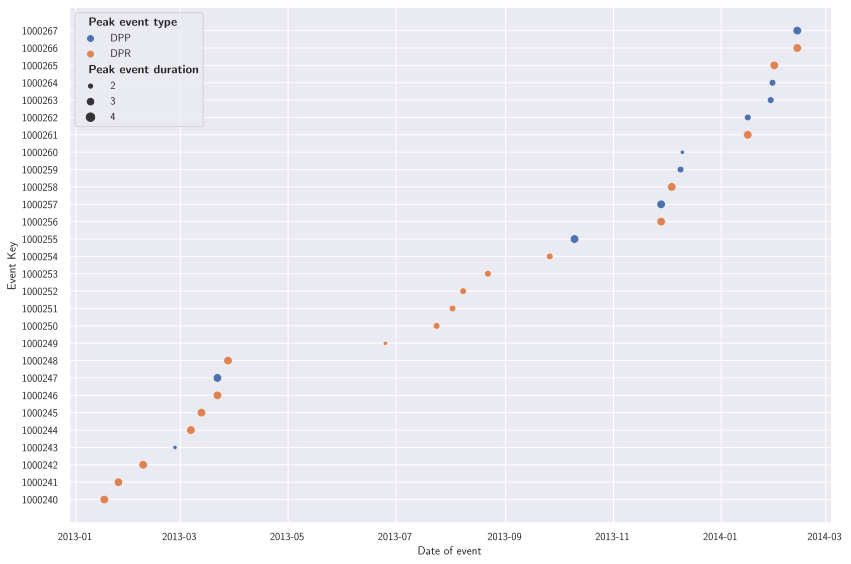

In [23]:
# activate latex text rendering for matplotlib
rc('text', usetex=True)

# Plot the seaborn graph
sns.set()
plt.figure(figsize=(12, 8))

ax = sns.scatterplot(x="EVENT_DATE", y="EVENT_KEY",
                     hue="PEAK_EVENT_TYPE", size="peak_event_duration",
                     data=peak_event_df.sort_values('EVENT_KEY', ascending=False))

# Change the axes labels and parts of legend 
ax.set(xlabel='Date of event', ylabel='Event Key')
ax.get_legend().get_texts()[0].set_text(r'\textbf{Peak event type}')
ax.get_legend().get_texts()[3].set_text(r'\textbf{Peak event duration}')

plt.tight_layout()

#plt.savefig("images/peak_event_duration.pdf")

plt.show()

We also calculate some basic info of when the DPR events have happened.

In [ ]:
# Get the median time of each event's start and end time 
date_offset_ser = peak_event_df.peak_event_duration.apply(lambda x: pd.DateOffset(hours=x/2))
peak_event_df['EVENT_DATETIME'] = peak_event_df.START_TIMESTAMP + date_offset_ser

peak_event_df.loc[:, 'Day'] = peak_event_df.EVENT_DATETIME.dt.day_name().values
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
peak_event_df['Day'] = pd.Categorical(peak_event_df['Day'], categories=cats, ordered=True)
peak_event_df.loc[:, 'Month'] = peak_event_df.EVENT_DATETIME.dt.month.values
peak_event_df.loc[:, 'Hour'] = peak_event_df.EVENT_DATETIME.dt.hour.values.astype(str)

In [ ]:
DPR_event_df = peak_event_df[peak_event_df.PEAK_EVENT_TYPE == 'DPR']

In [ ]:
sns.displot(DPR_event_df.Day)
plt.xlabel('')
plt.ylabel('Number of DPR events', fontsize=16)
plt.xticks(fontsize= 13)
plt.tight_layout()



plt.savefig("images/DPR_day.pdf")

plt.show()

In [ ]:
sns.displot(DPR_event_df.Month.sort_values())
plt.xlabel('Month')
plt.ylabel('Number of DPR events')

plt.show()

In [ ]:
sns.displot(DPR_event_df.Hour.sort_values())
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.xticks(fontsize= 13)

#plt.savefig("images/DPR_hour.pdf")
plt.show()

In [ ]:
# Check across seasons
winter_mask = DPR_event_df.Month.isin([6,7,8])
spring_mask = DPR_event_df.Month.isin([9,10,11])
summer_mask = DPR_event_df.Month.isin([12,1,2])
autumn_mask = DPR_event_df.Month.isin([3,4,5]) 

# Create the season column
DPR_event_df['season'] = np.zeros(DPR_event_df.shape[0], dtype='str')

DPR_event_df.loc[winter_mask, 'season'] = 'Winter'
DPR_event_df.loc[spring_mask, 'season'] = 'Spring'
DPR_event_df.loc[summer_mask, 'season'] = 'Summer'
DPR_event_df.loc[autumn_mask, 'season'] = 'Autumn'

cats_season = ['Spring', 'Summer', 'Autumn', 'Winter']
DPR_event_df['season'] = pd.Categorical(DPR_event_df['season'], categories=cats_season, ordered=True)

In [ ]:
# Create the plot
sns.displot(DPR_event_df.season)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize= 13)
plt.tight_layout()

#plt.savefig("images/DPR_season.pdf")
plt.show()